<a href="https://colab.research.google.com/github/ayushi15092002/mental-health-workload/blob/main/Functional_Connectivity_Feature_Selection_Embedded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
# from feature_selection import embedded_method
# plt.style.use('seaborn-colorblind')
# %matplotlib inline


## Load Dataset

In [ ]:
data = pd.read_excel(r'/content/drive/My Drive/drdo/features/min_max_fun_conn.xlsx')

In [ ]:
data.head(5)

,Coherence,Imaginary Coherence,Phase Locking Value,corrected imaginary PLV,Pairwise Phase Consistency,Phase Lag Index (PLI),Directed Phase Lag Index (DPLI),Weighted Phase Lag Index (WPLI),Debiased estimator of squared WPLI,y
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0
1,0.0,0.291424,0.0,0.0,0.000636,0.0,0.0,0.0,0.069174,1.0
2,0.0,0.291424,0.0,0.0,0.000636,0.0,0.0,0.0,0.069174,1.0
3,0.0,0.291424,0.0,0.0,0.000636,0.0,0.0,0.0,0.069174,1.0
4,0.0,0.291424,0.0,0.0,0.000636,0.0,0.0,0.0,0.069174,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['y'], axis=1), 
                                                    data.y, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((1880, 9), (471, 9))

## Lasso
Regularization with Lasso.Lasso (L1) has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model

In [ ]:
# linear models benefit from feature scaling

scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [ ]:
# fit the LR model
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
X = scaler.transform(X_train)
sel_.fit(X, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelectFromModel(estimator=LogisticRegression(C=1))

In [ ]:
# make a list with the selected features
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 9
selected features: 5
features with coefficients shrank to zero: 0


In [ ]:
selected_feat

Index(['Coherence', 'Phase Locking Value', 'corrected imaginary PLV',
       'Directed Phase Lag Index (DPLI)', 'Weighted Phase Lag Index (WPLI)'],
      dtype='object')

In [ ]:
# we can identify the removed features like this:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

IndexError: ignored

In [ ]:
# remove the features from the training and testing set

X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((1880, 5), (471, 5))

## Random Forest Importance


Feature ranking:
1. feature no:3 feature name:corrected imaginary PLV (0.117576)
2. feature no:1 feature name:Imaginary Coherence (0.117350)
3. feature no:8 feature name:Debiased estimator of squared WPLI (0.115628)
4. feature no:4 feature name:Pairwise Phase Consistency (0.112847)
5. feature no:5 feature name:Phase Lag Index (PLI) (0.112320)
6. feature no:6 feature name:Directed Phase Lag Index (DPLI) (0.111362)
7. feature no:7 feature name:Weighted Phase Lag Index (WPLI) (0.110308)
8. feature no:0 feature name:Coherence (0.102185)
9. feature no:2 feature name:Phase Locking Value (0.100425)


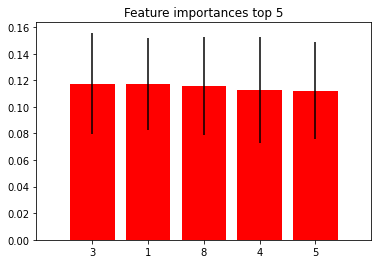

In [ ]:
model = rf_importance(X_train=X_train,y_train=y_train,
                             max_depth=10,top_n=5)

In [ ]:
# select features whose importance > threshold
from sklearn.feature_selection import SelectFromModel

# only 5 features have importance > 0.05
feature_selection = SelectFromModel(model, threshold=0.05,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]
selected_feat

Index(['Coherence', 'Imaginary Coherence', 'Phase Locking Value',
       'corrected imaginary PLV', 'Pairwise Phase Consistency',
       'Phase Lag Index (PLI)', 'Directed Phase Lag Index (DPLI)',
       'Weighted Phase Lag Index (WPLI)',
       'Debiased estimator of squared WPLI'],
      dtype='object')

In [ ]:
# only 12 features have importance > 2 times median
feature_selection2 = SelectFromModel(model, threshold='2*median',prefit=True) 
selected_feat2 = X_train.columns[(feature_selection2.get_support())]
selected_feat2

Index([], dtype='object')

## Gradient Boosted Trees Importance

Feature ranking:
1. feature no:1 feature name:Imaginary Coherence (0.132822)
2. feature no:5 feature name:Phase Lag Index (PLI) (0.121770)
3. feature no:0 feature name:Coherence (0.115981)
4. feature no:3 feature name:corrected imaginary PLV (0.114795)
5. feature no:4 feature name:Pairwise Phase Consistency (0.108312)
6. feature no:7 feature name:Weighted Phase Lag Index (WPLI) (0.107486)
7. feature no:6 feature name:Directed Phase Lag Index (DPLI) (0.100101)
8. feature no:8 feature name:Debiased estimator of squared WPLI (0.099388)
9. feature no:2 feature name:Phase Locking Value (0.099344)


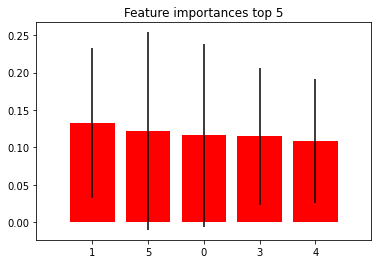

In [ ]:
model = gbt_importance(X_train=X_train,y_train=y_train,
                             max_depth=5,top_n=5)

In [ ]:
# select features whose importance > threshold

# only 8 features have importance > 0.01
feature_selection = SelectFromModel(model, threshold=0.01,prefit=True) 
selected_feat = X_train.columns[(feature_selection.get_support())]
selected_feat

Index(['Coherence', 'Imaginary Coherence', 'Phase Locking Value',
       'corrected imaginary PLV', 'Pairwise Phase Consistency',
       'Phase Lag Index (PLI)', 'Directed Phase Lag Index (DPLI)',
       'Weighted Phase Lag Index (WPLI)',
       'Debiased estimator of squared WPLI'],
      dtype='object')

In [ ]:
#import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier #RandomForestRegressor
#from sklearn.feature_selection import SelectFromModel

# 2018.11.27 Created by Eamon.Zhang

def rf_importance(X_train,y_train,max_depth=10,class_weight=None,top_n=15,n_estimators=50,random_state=0):
    
    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                    random_state=random_state,class_weight=class_weight,
                                    n_jobs=-1)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_labels = X_train.columns
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0) #  inter-trees variability. 
    print("Feature ranking:") 
#    l1,l2,l3,l4 = [],[],[],[]
    for f in range(X_train.shape[1]):
        print("%d. feature no:%d feature name:%s (%f)" % (f + 1, indices[f], feat_labels[indices[f]], importances[indices[f]]))
#        l1.append(f+1)
#        l2.append(indices[f])
#        l3.append(feat_labels[indices[f]])
#        l4.append(importances[indices[f]])
    #feature_rank = pd.Dataframe(zip(l1,l2,l3,l4),columns=['id','indice','feature','importances'])
    
    # plotting
    indices = indices[0:top_n]
    plt.figure()
    plt.title("Feature importances top %d" % top_n)
    plt.bar(range(top_n), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(top_n), indices)
    plt.xlim([-1,top_n])
    plt.show() 
    
    return model


def gbt_importance(X_train,y_train,max_depth=10,top_n=15,n_estimators=50,random_state=0):
    
    model = GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                       random_state=random_state)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_labels = X_train.columns
    std = np.std([tree[0].feature_importances_ for tree in model.estimators_],
                 axis=0) #  inter-trees variability. 
    print("Feature ranking:")   
#    l1,l2,l3,l4 = [],[],[],[]
    for f in range(X_train.shape[1]):
        print("%d. feature no:%d feature name:%s (%f)" % (f + 1, indices[f], feat_labels[indices[f]], importances[indices[f]]))
#        l1.append(f+1)
#        l2.append(indices[f])
#        l3.append(feat_labels[indices[f]])
#        l4.append(importances[indices[f]])
#    feature_rank = pd.Dataframe(zip(l1,l2,l3,l4),columns=['id','indice','feature','importances'])   
    # plotting
    indices = indices[0:top_n]
    plt.figure()
    plt.title("Feature importances top %d" % top_n)
    plt.bar(range(top_n), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(top_n), indices)
    plt.xlim([-1,top_n])
    plt.show() 
    
    return model